In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import hdbscan
from hdbscan.validity import validity_index

import umap
import umap.plot as uplot

from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

import matplotlib.pyplot as plt

sns.set_theme()

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, e

In [2]:
#Load the data 
# Load the data
zoo_path = '../Aglo-hierarchical-clustering/zoo.csv'
zoo_df = pd.read_csv(zoo_path)

# Load class mapping
class_mappings = '../Aglo-hierarchical-clustering/class.csv'
class_mapper = pd.read_csv(class_mappings)

In [3]:
zoo_df.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [4]:
class_mapper

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


In [5]:
zoo_df.shape

(101, 18)

In [6]:
zoo_df.isna().sum(axis=0)

animal_name    0
hair           0
feathers       0
eggs           0
milk           0
airborne       0
aquatic        0
predator       0
toothed        0
backbone       0
breathes       0
venomous       0
fins           0
legs           0
tail           0
domestic       0
catsize        0
class_type     0
dtype: int64

In [7]:
# Check number of unique animals 
zoo_df['animal_name'].nunique()

100

In [8]:
# Drop duplicates since there should be one species per row
zoo_df = zoo_df.drop_duplicates('animal_name')
zoo_df.shape

(100, 18)

In [9]:
# Map class id to class name
class_map_dict = class_mapper.set_index('Class_Number')['Class_Type'].to_dict()
zoo_df['class_type'] = zoo_df['class_type'].map(class_map_dict)

# Extract class as separate object and drop class from zoo_df
animal_class = zoo_df['class_type'] 
zoo_df = zoo_df.drop(columns=['class_type'])

In [10]:
# Set animal name as index
zoo_df = zoo_df.set_index('animal_name', drop=True)

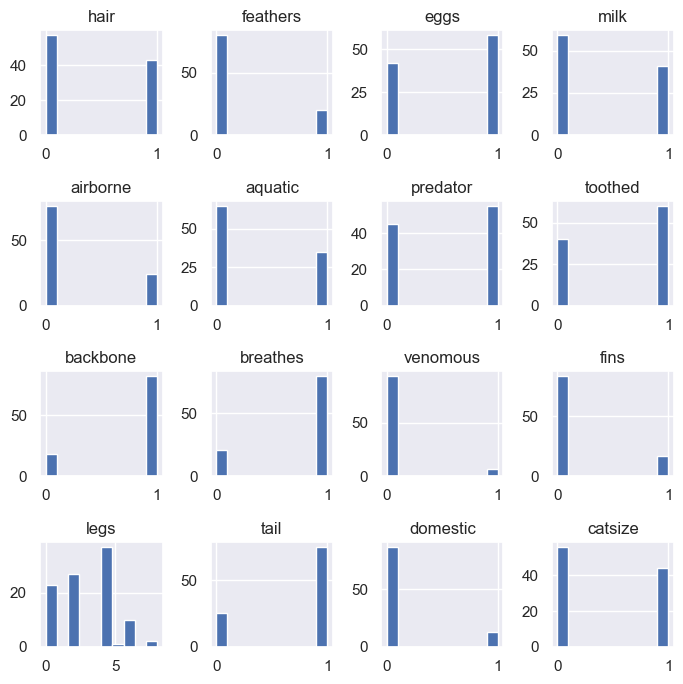

In [11]:
_ = zoo_df.hist(figsize=(7,7))
plt.tight_layout()

In [12]:
zoo_umap = umap.UMAP(metric='hamming', n_neighbors=20).fit(zoo_df.values)

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


<Axes: >

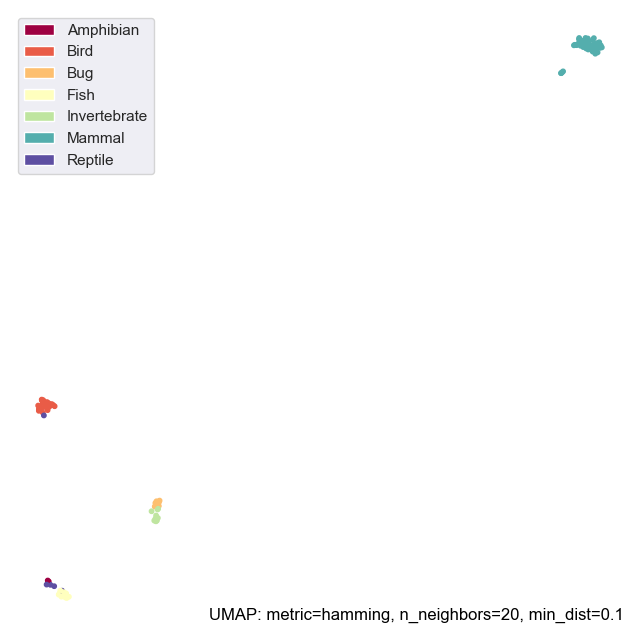

In [13]:
uplot.points(zoo_umap, labels=animal_class)

# Implement HDBCAN Algorithm

In [14]:
def print_clustering_stats(clusterer, data_df, data_labels, metric):
    
    # Create reduced version of data (exclude noise)
    np_labels = np.array(clusterer.labels_)
    non_noise_idx = np.where(np_labels != -1)

    non_noise_labels = np_labels[non_noise_idx]
    data_labels_sub = data_labels[non_noise_idx]
    digits_data_sub = data_df[non_noise_idx]
    noise_size = np_labels.shape[0] - non_noise_labels.shape[0]
    
    print('ARI : {}'.format(adjusted_rand_score(np_labels, data_labels)))
    print('ARI sub : {}'.format(adjusted_rand_score(non_noise_labels, data_labels_sub)))
    print('noise size : {}'.format(noise_size))
    print('Silouethe : {}'.format(silhouette_score(data_df, np_labels, metric=metric)))
    print('Silouethe sub : {}'.format(silhouette_score(digits_data_sub, data_labels_sub, metric=metric)))
    print('DBCV : {}'.format(validity_index(data_df, np_labels, metric=metric)))
    

ARI : 0.74604093695645
ARI sub : 0.8952399847794308
noise size : 13
Silouethe : 0.49390425041214897
Silouethe sub : 0.5937038750459015
DBCV : 0.4167546393862027


/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

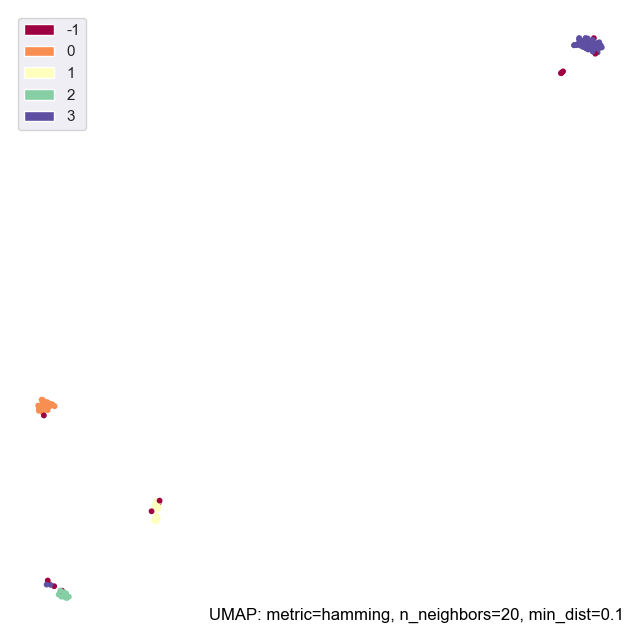

In [15]:
clusterer = hdbscan.HDBSCAN(
    min_samples=5, 
    min_cluster_size=10, 
    gen_min_span_tree=True, 
    metric='hamming'
)
clusterer.fit(zoo_df.values)

print_clustering_stats(
    clusterer=clusterer,
    data_df=zoo_df.values, 
    data_labels=animal_class.values,
    metric='hamming'
)

uplot.points(zoo_umap, labels=clusterer.labels_)

ARI : 0.9386944526063976
ARI sub : 0.9658871545266514
noise size : 2
Silouethe : 0.5604283854573139
Silouethe sub : 0.5513043758961489
DBCV : 0.4460472832511994


/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

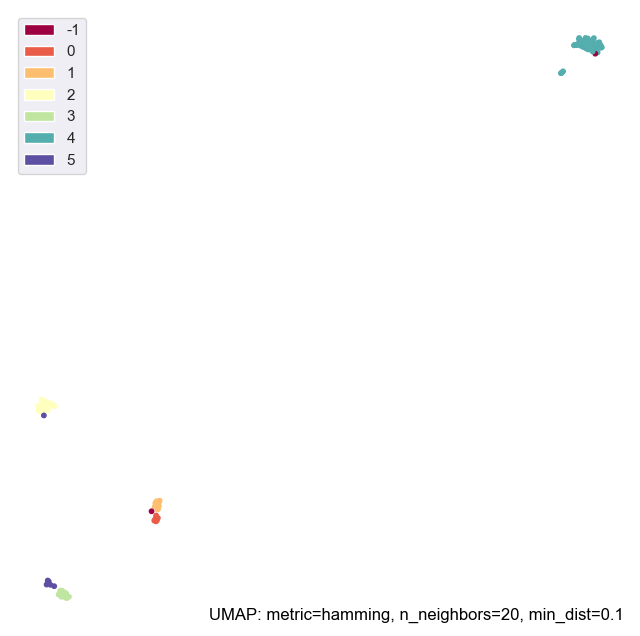

In [16]:
clusterer = hdbscan.HDBSCAN(
    min_samples=2, 
    min_cluster_size=7, 
    gen_min_span_tree=True, 
    metric='hamming'
)
clusterer.fit(zoo_df.values)

print_clustering_stats(
    clusterer=clusterer,
    data_df=zoo_df.values, 
    data_labels=animal_class.values,
    metric='hamming'
)

uplot.points(zoo_umap, labels=clusterer.labels_)